# Quick & Dirty Template to Loading & Modeling

## Step 1: Loading stuff
Getting all the libraries, defining useful functions, loading data

In [1]:
# We will need the RBCPath type from the rbclib package to load data from the RBC.
from rbclib import RBCPath

# We'll also want to load some data directly from the filesystem.
from pathlib import Path

# We'll want to load/process some of the data using pandas and numpy.
import pandas as pd
import numpy as np
import re

In [2]:
# Participant meta-data is generally located in the BIDS repository for each
# study:
rbcdata_path = Path('/home/jovyan/shared/data/RBC')
train_filepath = rbcdata_path / 'train_participants.tsv'
test_filepath = rbcdata_path / 'test_participants.tsv'

# Load the PNC participants TSV files...
with train_filepath.open('r') as f:
    train_data = pd.read_csv(f, sep='\t')
with test_filepath.open('r') as f:
    test_data = pd.read_csv(f, sep='\t')

# We can also concatenate the two datasets into a single dataset of all
# study participants:
all_data = pd.concat([train_data, test_data])

In [3]:
# Tien's functions!
def load_fsdata_raw(participant_id, local_cache_dir=Path.home() / "cache"):
    """
    Load the raw FreeSurfer TSV for a PNC participant.
    Returns a long-form DataFrame.
    """
    local_cache_dir = Path(local_cache_dir)
    local_cache_dir.mkdir(exist_ok=True)
    pnc_fspath = RBCPath(
        "rbc://PNC_FreeSurfer/freesurfer",
        local_cache_dir=local_cache_dir
    )
    subdir = pnc_fspath / f"sub-{participant_id}"
    tsv_path = subdir / f"sub-{participant_id}_regionsurfacestats.tsv"

    return pd.read_csv(tsv_path, sep="\t")


def filter_by_atlas(df, atlas_substr):
    mask = df["atlas"].astype(str).str.contains(atlas_substr, case=False, na=False)
    if not mask.any():
        available = sorted(df["atlas"].dropna().unique())
        raise ValueError(
            f"No atlas rows contained '{atlas_substr}'.\n"
            f"Available atlas names:\n  " + "\n  ".join(available)
        )
    df_by_atlas = df[mask].copy()
    return df_by_atlas

def select_measure(df, measure):
    cols = ["subject_id","atlas","hemisphere","StructName", measure]
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    df_by_measure = df[cols].copy()
    return df_by_measure

def sanitize(col):
    # replace any sequence of non-alphanumeric chars with a single underscore
    clean = re.sub(r'[^0-9A-Za-z]+', '_', col)
    # collapse repeated underscores
    clean = re.sub(r'_{2,}', '_', clean)
    # strip leading/trailing underscores
    return clean.strip('_')

def pivot(df, measure):
    """
    Build one-row DataFrame:
      subject_id, and
      { sanitized hemisphere_atlas_StructName_measure: value }
    """
    subj = df['subject_id'].iloc[0]
    out = {'subject_id': subj}
    for _, row in df.iterrows():
        raw = f"{row['hemisphere']}_{row['atlas']}_{row['StructName']}_{measure}"
        col = sanitize(raw)
        out[col] = row[measure]
    return pd.DataFrame([out])

def load_and_pivot_fsdata(participant_id,
                          atlas,
                          measure,
                          local_cache_dir=Path.home()/"cache"):
    """
    1) load raw
    2) filter atlas
    3) select just the one measure
    4) pivot into a single-row wide DataFrame
    """
    fsdata_raw = load_fsdata_raw(participant_id, local_cache_dir)
    fsdata_raw_by_atlas = filter_by_atlas(fsdata_raw, atlas)
    fsdata_raw_by_atlas_by_measure = select_measure(fsdata_raw_by_atlas, measure)
    df_wide = pivot(fsdata_raw_by_atlas_by_measure, measure)
    return df_wide



## Step 2: Removing Not Informative Subjects & Loading a Few Subjects In (for now)
For now, let's load a few subjects data and try making a model with them

### Removing Not Informative Subjects
A lot of our subjects are at the minimum value for p_factor, so it's probably not helpful to include them when trying to predict p_factor (because it will bias the model towards predicting lower p_factors than expected)

-1.608374501
177


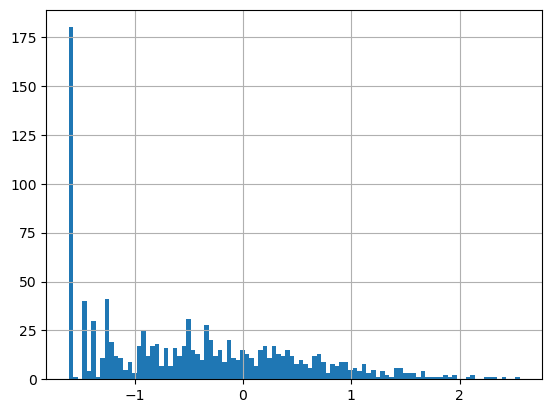

In [5]:
train_data['p_factor'].hist(bins=100)
print(train_data['p_factor'].min())
print(train_data['p_factor'].value_counts()[train_data['p_factor'].min()])

<Axes: >

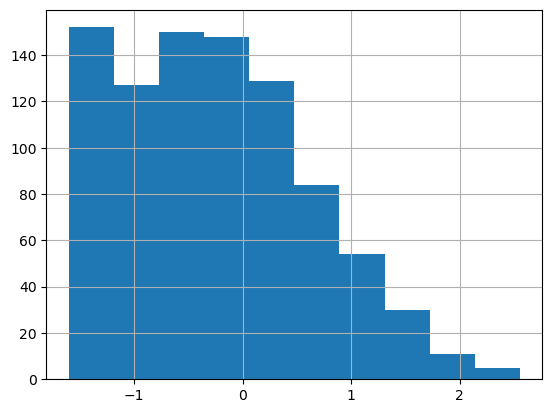

In [6]:
# cleaned train data (remove min):
min_val_idx = train_data['p_factor'] == train_data['p_factor'].min()
removed_train_data = train_data[min_val_idx].copy()
clean_train_data = train_data[~min_val_idx]
clean_train_data['p_factor'].hist()

### Getting a Small Subset of Subjects to Work With (for now)
bc it takes too long to download everybody

In [11]:
clean_train_data = clean_train_data.reset_index()

In [21]:
num_subjects = 5
idx_max = clean_train_data.shape[0]

# generate list of random subjects
rand_ii = np.random.randint(low=0, high=idx_max, size=num_subjects)
rand_subjects = clean_train_data['participant_id'][rand_ii].values
print(rand_subjects)

[2166835733 1786969075 3216964316  348742929 3392963865]


In [22]:
# load subjects' data
dfs = []
for subject_id in rand_subjects:
    df = load_fsdata_raw(subject_id)
    dfs.append(df)

training_subset = pd.concat(dfs, ignore_index=True)


In [23]:
training_subset.head()

,subject_id,session_id,atlas,hemisphere,StructName,NumVert,SurfArea,GrayVol,ThickAvg,ThickStd,...,StdDev_wgpct,Min_wgpct,Max_wgpct,Range_wgpct,SNR_wgpct,Mean_piallgi,StdDev_piallgi,Min_piallgi,Max_piallgi,Range_piallgi
0,sub-2166835733,NaN,aparc.DKTatlas,lh,caudalanteriorcingulate,2364,1561,5206,3.076,0.705,...,4.8876,10.0981,43.4657,33.3676,5.3146,2.1999,0.0788,1.9823,2.3426,0.3603
1,sub-2166835733,NaN,aparc.DKTatlas,lh,caudalmiddlefrontal,4524,2932,9546,2.934,0.512,...,4.6753,-2.4241,40.8911,43.3152,5.2304,3.7395,0.4086,2.7202,4.3641,1.6439
2,sub-2166835733,NaN,aparc.DKTatlas,lh,cuneus,4525,2790,6352,2.123,0.503,...,5.7805,-3.3307,32.8069,36.1376,2.9612,3.4247,0.3262,2.4627,3.9467,1.4840
3,sub-2166835733,NaN,aparc.DKTatlas,lh,entorhinal,905,619,2721,3.218,0.896,...,7.1711,-0.7414,43.5325,44.2739,3.2636,2.7230,0.0873,2.5151,2.9452,0.4301
4,sub-2166835733,NaN,aparc.DKTatlas,lh,fusiform,5191,3384,10472,2.836,0.576,...,6.2126,-4.3186,45.3247,49.6434,3.6877,2.8100,0.1161,2.5077,3.1397,0.6320


## Step 3: Picking Some Features to Model?
Let's pick an atlas and a brain measure to use in a model

In [25]:
print('Atlases:', training_subset['atlas'].unique())
print('Brain Measures (mostly):', training_subset.columns) 

Atlases: ['aparc.DKTatlas' 'aparc.a2009s' 'aparc' 'BA_exvivo' 'AAL' 'CC200' 'CC400'
 'glasser' 'gordon333dil' 'HOCPATh25' 'Juelich' 'PALS_B12_Brodmann'
 'Schaefer2018_1000Parcels_17Networks_order'
 'Schaefer2018_1000Parcels_7Networks_order'
 'Schaefer2018_100Parcels_17Networks_order'
 'Schaefer2018_100Parcels_7Networks_order'
 'Schaefer2018_200Parcels_17Networks_order'
 'Schaefer2018_200Parcels_7Networks_order'
 'Schaefer2018_300Parcels_17Networks_order'
 'Schaefer2018_300Parcels_7Networks_order'
 'Schaefer2018_400Parcels_17Networks_order'
 'Schaefer2018_400Parcels_7Networks_order'
 'Schaefer2018_500Parcels_17Networks_order'
 'Schaefer2018_500Parcels_7Networks_order'
 'Schaefer2018_600Parcels_17Networks_order'
 'Schaefer2018_600Parcels_7Networks_order'
 'Schaefer2018_700Parcels_17Networks_order'
 'Schaefer2018_700Parcels_7Networks_order'
 'Schaefer2018_800Parcels_17Networks_order'
 'Schaefer2018_800Parcels_7Networks_order'
 'Schaefer2018_900Parcels_17Networks_order'
 'Schaefer2018_900P

In [36]:
# let's pick something!
atlas = 'aparc.DKTatlas'
measure = 'GrayVol'

In [37]:
fsdata_raw_by_atlas = filter_by_atlas(training_subset, atlas)
fsdata_raw_by_atlas_by_measure = select_measure(fsdata_raw_by_atlas, measure)


In [38]:
fsdata_raw_by_atlas_by_measure

,subject_id,atlas,hemisphere,StructName,GrayVol
0,sub-2166835733,aparc.DKTatlas,lh,caudalanteriorcingulate,5206
1,sub-2166835733,aparc.DKTatlas,lh,caudalmiddlefrontal,9546
2,sub-2166835733,aparc.DKTatlas,lh,cuneus,6352
3,sub-2166835733,aparc.DKTatlas,lh,entorhinal,2721
4,sub-2166835733,aparc.DKTatlas,lh,fusiform,10472
...,...,...,...,...,...
55012,sub-3392963865,aparc.DKTatlas,rh,superiorparietal,15424
55013,sub-3392963865,aparc.DKTatlas,rh,superiortemporal,18766
55014,sub-3392963865,aparc.DKTatlas,rh,supramarginal,14245
55015,sub-3392963865,aparc.DKTatlas,rh,transversetemporal,1150


In [ ]:
# 